In [1]:
import pandas as pd
from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes

<h1>CSS Stylesheet</h1>

In [2]:
css_style = """
h1 {
    color: black;
    font-family: 'Segoe UI', 'Gill Sans MT', Calibri, 'Trebuchet MS', sans-serif;
    font-size: 35px !important;
    padding-bottom: 10px;
    padding-top: 10px;
    border-bottom: 5px solid navy;
    border-top: 5px solid navy;
    font-variant: small-caps;
    text-align: center;
    margin-bottom: 25px;
}

h3 {
    color : dimgray;    
}

.all {
/*This class is the default class for <div> so it does not interact with jupyter notebook structure */
text-align: justify;
font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
margin-right: 2px;
}

.titlediv {
    /*This class is the default class for <div> so it does not interact with jupyter notebook structure */
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    border: 5px solid navy;
    padding-top: 30px;
    padding-bottom: 30px;
    padding-left: 5px;
    padding-right: 5px;
    margin-bottom: 10px;
    }

.titlediv_2 {
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    text-align: center !important;
    }

.titlep {
    font-size : 50px;
    text-align: center !important;
    font-variant: small-caps;
}   

.titlep_2 {
    font-size : 30px;
    text-align: center !important;
    margin-top: 10px;
}  

.title_sp {
    text-align: center !important;
    font-size: 20px !important;
    font-weight: bold;
}

.signature {
    margin-top: 60px;
    padding-top: 15px;
    border-top: 2px solid black;
    text-align: right !important;
    font-family:'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
}

.obj {
    text-align: justify;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-right: 100px;
    border: 2px solid lightcoral;
    padding: 15px;
}

p {
    text-align: justify !important;
}

.intro {
    font-style: italic;
}

.conclusion {
    border: 5px solid navy;
    margin-top: 50px;
    padding: 10px;
}

.conclusion h3 {
    color:black;
    font-variant: small-caps;
}

.small-caps {
    font-variant: small-caps;
}

table {
    margin-right: 10px !important;
    font-size: 14px !important;
    text-align: center !important;
}

.table_1 {
    border: 3px solid black !important;
    width: 100% !important;
}

.table_1 td, .table_1, th {
    border: 1px solid black;
}

.head_tr {
    background-color: dimgray !important;
    color: white;
    border: 3px solid black !important;
}

th, td {
    padding: 8px !important;
    text-align: center !important;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    border: 1.5px solid black; 
}


.recap_table td, .recap_table th {
    height: 50px;
    width: 180px;
}

.recap_table th {
    font-size: 18px;
}

.col_1 {
    text-align: right !important;
    width: 50 !important;
}

.col_group {
    width: 200px;
    background-color: #d4c9df !important;
    text-align: center;
    height: 5px !important;
    font-size: 16 !important;
    font-weight: bold;
}

.columns {
    display: flex;
    flex-wrap: wrap;
}

.column {
    flex: 1;
    padding: 10px;
    text-align: justify;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-right: 50px;
}
"""
    
HTML(f'<style>{css_style}</style>')

In [3]:
def matrix_display(y_test, y_pred):
    
    labels = pd.crosstab(y_test, y_pred).unstack().reset_index().rename(columns = {"col_0" : 'pred', 0:"n"})
    labels['label'] = labels.apply(lambda row: 
                                   "TN" if row['pred'] == 0.0 and row['cardio'] == 0.0
                                   else "FP" if row['pred'] == 1.0 and row['cardio'] == 0.0
                                   else "FN" if row['pred'] == 0.0 and row['cardio'] == 1.0
                                   else "TP" if row['pred'] == 1.0 and row['cardio'] == 1.0
                                   else np.nan(), axis = 1                               
                                  )
    labels.set_index('label', inplace = True)
    
    TN = labels.at['TN', 'n']
    FP = labels.at['FP', 'n']
    TP = labels.at['TP', 'n']
    FN = labels.at['FN', 'n']
    
    TN_p = TN/y_test.value_counts()[0.0]
    FP_p = FP/y_test.value_counts()[0.0]
    TP_p = TP/y_test.value_counts()[1.0]
    FN_p = FN/y_test.value_counts()[1.0]
    
    return    f""" <table style = 'border 1px solid black; width : 70%; border: 1px solid black'>
        <tr style = 'background-color: gray; color: white; border: 1px solid black'>
            <th>Classification</th>
            <th>Samples (<i>n</i>)</th>
            <th>Samples (%)</th>
        </tr>
        <tr>
            <th colspan = "3" style = 'border: 1px solid black; background-color: lightcyan; font-variant: small-caps; font-weight:bold; text-align: left ! important; line-height: 0.6'>Class 0: Absence of CV disease</th>
        </tr>
        <tr>
            <td>True Negatives</td>
            <td>{TN}</td>
            <td style = 'color: green; font-weight: bold'>{TN_p:.1%}</td>
        </tr>
        <tr>
            <td>False Positives</td>
            <td>{FP}</td>
            <td style = 'color: firebrick; font-weight: bold'>{FP_p:.1%}</td>
        </tr>
        <tr>
            <th colspan = "3" style = 'border: 1px solid black; background-color: lightcyan; font-variant: small-caps; font-weight:bold; text-align: left ! important; line-height: 0.6'>Class 1: Presence of CV disease</th>
        </tr>
        <tr>
            <td>True Positives</td>
            <td>{TP}</td>
            <td style = 'color: green; font-weight: bold'>{TP_p:.1%}</td>
        </tr>
        <tr>
            <td>False Negatives</td>
            <td>{FN}</td>
            <td style = 'color: firebrick; font-weight: bold'>{FN_p:.1%}</td>
        </tr>
    </table>"""


def classification_plot(y_test, y_pred):
    
    labels = pd.crosstab(y_test, y_pred).unstack().reset_index().rename(columns = {"col_0" : 'pred', 0:"n"})
    labels['label'] = labels.apply(lambda row: 
                               "TN" if row['pred'] == 0.0 and row['cardio'] == 0.0
                               else "FP" if row['pred'] == 1.0 and row['cardio'] == 0.0
                               else "FN" if row['pred'] == 0.0 and row['cardio'] == 1.0
                               else "TP" if row['pred'] == 1.0 and row['cardio'] == 1.0
                               else np.nan(), axis = 1                               
                              )
    labels.set_index('label', inplace = True)
    
    TN = labels.at['TN', 'n']
    FP = labels.at['FP', 'n']
    TP = labels.at['TP', 'n']
    FN = labels.at['FN', 'n']

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 6))

    plt.subplots_adjust(wspace = 1)

    ax[0].pie([TN, FP], labels = ['True Negatives', 'False Positives'], autopct = '%.0f%%', startangle=90, colors = ['palegreen', 'lightcoral'], wedgeprops = {'edgecolor' : 'black'}, textprops = {'fontsize' : '14'})
    ax[0].set_title('Classification: Class 0', fontdict = fontdict_title)
    ax[1].pie([TP, FN], labels = ['True Positives','False Negatives'], autopct = '%.0f%%', startangle=90, colors = ['palegreen', 'lightcoral'], wedgeprops = {'edgecolor' : 'black'}, textprops = {'fontsize' : '14'})
    ax[1].set_title('Classification: Class 1', fontdict = fontdict_title)

    plt.show()  

def perf_barplot(classification_rep):
    
    dfrep = pd.DataFrame(classification_rep).reset_index().rename(columns={'index': 'Metric'})
    dfrep_m = pd.melt(dfrep[['Metric', '0.0', '1.0']], id_vars = "Metric", var_name = "Class", value_name = "Score")
    dfrep_m2 = pd.merge(dfrep_m, dfrep[['Metric', 'accuracy', 'macro avg', 'weighted avg']], on = "Metric", how = "left")
    dfrep_m2.loc[dfrep_m2["Metric"] != "support", ["Score", "macro avg", "weighted avg"]] *= 100
    dfrep_m2["accuracy"] *= 100
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5))
    plt.subplots_adjust(wspace = 0.3)

    sns.barplot(
        x = 'Metric', 
        y = "Score", 
        data = dfrep_m2.loc[dfrep_m2["Metric"] != "support"], 
        hue = "Class",
        palette = ['yellow', 'darkorchid'],
        edgecolor = "black",
    )
    
    for y in [50, 75, 90, 100]:
        ax.axhline(y = y, linestyle = 'dotted', color = 'black')
        ax.text(2.55, y, f'{y}%')
    
    ax.set_xticklabels(ax.get_xticklabels(), fontdict = {"size" : "12"})
    ax.set_xlabel('Metrics', fontdict = fontdict_labels)
    ax.set_ylim([0,105])

    
    ax.set_yticks(ticks = range(0,105,10), labels = range(0,105,10))
    ax.set_ylabel('Score (%)', fontdict = fontdict_labels)
    ax.set_title('Classification Performances', fontdict = fontdict_title)
    
    handles, _ = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles, labels=['Class 0', 'Class 1'], title= None, framealpha = 1, facecolor = 'white', edgecolor = 'black')
    legend.get_title().set_fontsize('12')
    for text in legend.get_texts():
        text.set_fontsize('10')
    
    plt.show()    
      
def report_table(perf_report):
    """
    Displays a classification report in a formatted HTML table.

    Parameters:
    - report (dict): A dictionary containing classification report metrics, typically generated by
      scikit-learn's `classification_report` function.

    Returns:
    - None
    """
    display(HTML(f"""
        <div class = 'all'>
            <h3>Detailed Metrics</h3>
            <table style = 'border: 1px solid black; width: 70%'>
                <tr style = 'border: 1px solid black; color: white; background-color: grey'>
                    <th style = 'border-right: 1px solid black'>Metric</th>
                    <th>Class 0 <br>Controls</th>
                    <th>Class 1 <br>Patients</th>
                    <th>Macro Average</th>
                    <th>Weighted Average</th>
                </tr>
                <tr style = 'border-bottom: 1px solid black'>
                    <td style = 'border-right: 1px solid black'><b>Accuracy</b></td>
                    <td colspan = "4"><b>{perf_report['accuracy']:.1%}</b></td>
                </tr>
                <tr>
                    <td style = 'border-right: 1px solid black'><b>Precision</b></td>
                    <td>{perf_report['0.0']['precision']:.1%}</td>
                    <td>{perf_report['1.0']['precision']:.1%}</td>
                    <td>{perf_report['macro avg']['precision']:.1%}</td>
                    <td>{perf_report['weighted avg']['precision']:.1%}</td>
                </tr>
                <tr>
                    <td style = 'border-right: 1px solid black'><b>Recall</b></td>
                    <td>{perf_report['0.0']['recall']:.1%}</td>
                    <td>{perf_report['1.0']['recall']:.1%}</td>
                    <td>{perf_report['macro avg']['recall']:.1%}</td>
                    <td>{perf_report['weighted avg']['recall']:.1%}</td>
                </tr>
                <tr>
                    <td style = 'border-right: 1px solid black'><b>f1-score</b></td>
                    <td>{perf_report['0.0']['f1-score']:.1%}</td>
                    <td>{perf_report['1.0']['f1-score']:.1%}</td>
                    <td>{perf_report['macro avg']['f1-score']:.1%}</td>
                    <td>{perf_report['weighted avg']['f1-score']:.1%}</td>
                </tr>
                <tr>
                    <td style = 'border-right: 1px solid black'><b>Support</b></td>
                    <td>{perf_report['0.0']['support']}</td>
                    <td>{perf_report['1.0']['support']}</td>
                    <td>{perf_report['macro avg']['support']}</td>
                    <td>{perf_report['weighted avg']['support']}</td>
                </tr>
            </table>
        </div>
    """))
    
    
# Utilitaries for data viz
palette_cardio = {"0":'lightcyan', "1": 'firebrick'}
palette_sex = {"female": "coral", "male" : "seagreen"}
fontdict_title = {'color' : 'navy', 'family' : 'Trebuchet MS', 'size' : 16, 'weight' : 'bold'}
fontdict_labels = {'color': 'black', 'family': 'Trebuchet MS', 'size' : 14}

<h4>Preprocessing 2: drop smoke, alco, active, height, female_sex</h4>

,age,weight,ap_hi,ap_lo,cholesterol,gluc,cardio,bmi,ap_m
0,0.44,0.075687,0.235294,0.255474,0.0,0.0,0.0,0.103933,0.256154
1,0.64,0.229739,0.411765,0.328467,1.0,0.0,1.0,0.285112,0.384615
2,0.48,0.089082,0.352941,0.182482,1.0,0.0,1.0,0.125000,0.256154
3,0.36,0.209645,0.470588,0.401460,0.0,0.0,1.0,0.198034,0.461538
4,0.32,0.035499,0.176471,0.109489,0.0,0.0,0.0,0.117978,0.127692


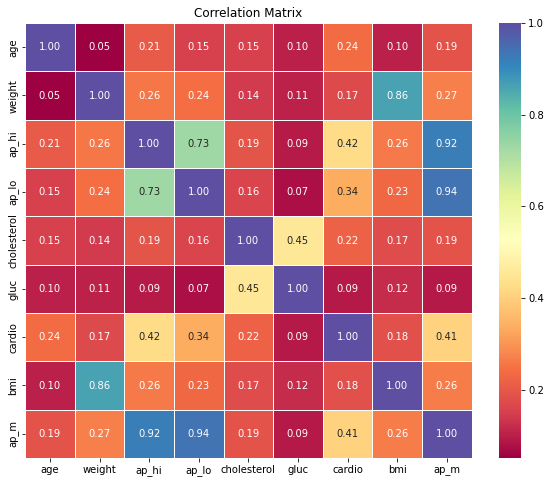

In [4]:
df_raw = pd.read_csv('clean_cvd.csv', sep = ",")        # This df should not be modified
df = pd.read_csv('clean_cvd.csv', sep = ",")

df['age'] = df['age'].astype('int')            
df = df.drop(['age_group', 'ap_aha', 'lifestyle', 'healthy_ls'], axis =1)   # Dropping created features that did not prove usefull
df['bmi'] = df['bmi'].round(1)
df['ap_m'] = df['ap_m'].round(1)

# Encoding sex as binary, renaming it "female sex"
sex_map = {
    "female" : 1,
    "male" : 0
}

df["sex"] = df["sex"].map(sex_map)
df = df.rename(columns = {"sex" : "female_sex"})

# Encoding ordered cat features

le = LabelEncoder()
df['cholesterol'] = le.fit_transform(df['cholesterol'])
df['gluc'] = le.fit_transform(df['gluc'])

# MinMax scaling

scaler = MinMaxScaler()
cols = df.columns
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns = cols)
df = df.drop(["smoke", "alco", "active", "height", "female_sex"], axis = 1)

display(df.head())

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='Spectral', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# Train and Test sets

X = df.drop('cardio', axis = 1)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41)



In [5]:
## SVM

svm = SVC(C= 0.1, kernel = 'rbf', gamma = 10, random_state = 46)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_params = svm.get_params()

svm2_report = classification_report(y_test, svm_pred, output_dict = True)


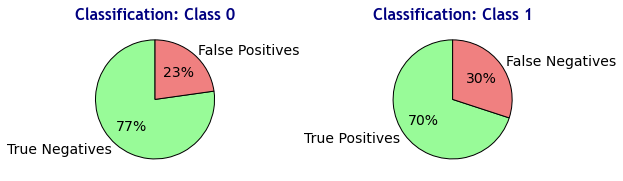

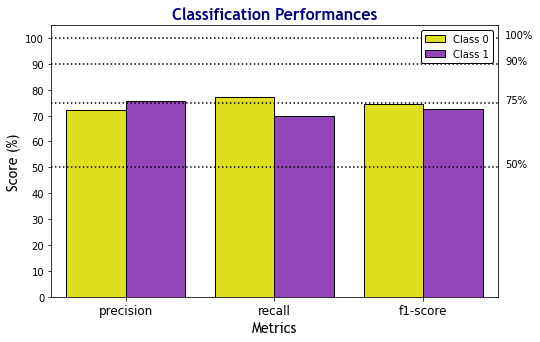

In [6]:
display(HTML(f"""
<div class = 'all'>
    <h1>Support Vector Machine</h1>

<div class ='all'>
        <h2>Classification Results</h3>
    {matrix_display(y_test, svm_pred)}
</div>
"""))

classification_plot(y_test, svm_pred)        
display(HTML(f"""
<div class = 'all'>
    <h2>Metrics</h3>
</div>
"""))

perf_barplot(svm2_report)
report_table(svm2_report)
